# Plot turbine power

In [1]:
# Add any possible locations of amr-wind-frontend here                                                                                      
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Important header information                                                                                                              
#import postprolib as pp

# Load the libraries                                                                                                                        
#import postproamrwindsample as ppsample
import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import xarray as xr
#import argparse
import pickle
import pandas as pd
from netCDF4 import Dataset
import glob

# Make all plots inline 
%matplotlib inline

In [2]:
def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

getturbnames = lambda df: [x[1]['# name'] for x in df.iterrows()]

def setfigtextsize(ax, fsize):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.get_offset_text()] + ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(fsize)
    return
        
# Helper to read the OpenFAST out file
readoutfile = lambda f: pd.read_csv(f,sep='\s+',skiprows=(0,1,2,3,4,5,7), header=(0),skipinitialspace=True)

In [3]:
# Start the AMR-Wind case
setupdir     = '/ccs/proj/cfd162/lcheung/AWAKEN_summit_setup/UnstableABL_farmrun1/'
rundir       = '/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/testturbs/'
turbdir      = rundir+'/post_processing/actuator64500/'
summitcsv    = 'UnstableABL_farmrun_turbines.csv'
OFoutdir     = 'post_processing/AFturbpower/'
OFdirsuffix  = '_OpenFAST3p3_NREL2p8-127.bugfix'
OFturbpattern= '*' #'NREL-2p8-127.*out'

In [4]:
genefficiency = 0.90
scale         = 1000

In [5]:
fontsize = 8

## Plot Joukowski disk power

In [6]:
farmlist = [{'title':'Thunder Ranch',   'suffix':'-TR'},
            {'title':'Chisholm View',   'suffix':'-CV'},
            {'title':'Armadillo Flats', 'suffix':'-AF'},
            {'title':'Breckinridge',    'suffix':'-BR'},
           ]

Pulling data for Thunder Ranch
Pulling data for Chisholm View
Pulling data for Armadillo Flats
Pulling data for Breckinridge


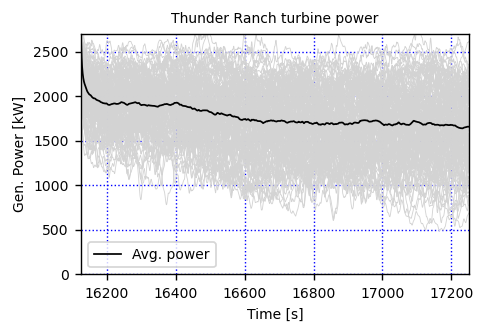

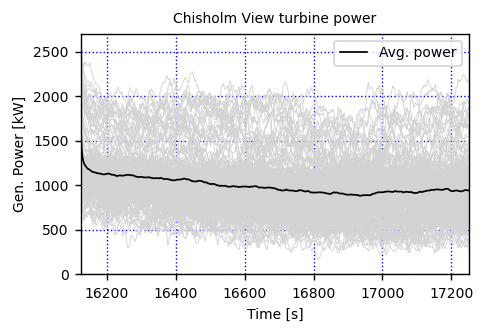

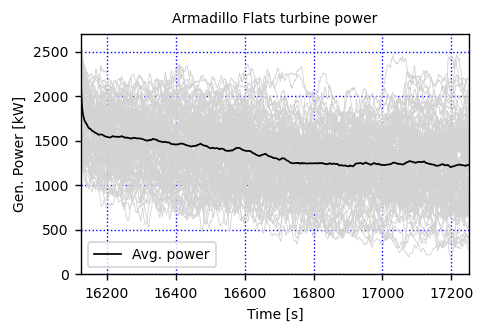

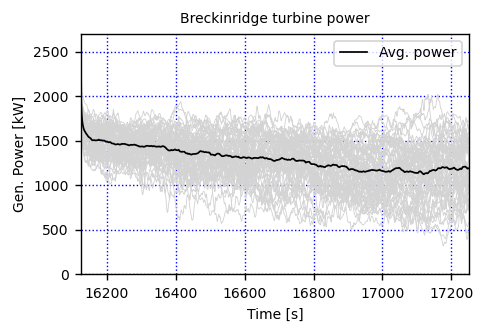

In [7]:
for farm in farmlist:
    print('Pulling data for '+farm['title'])
    turblist = getturbnames(getTurbSubset(setupdir+'/'+summitcsv, farm['suffix']))
    avgpower = None
    fig, ax = plt.subplots(1,1,figsize=(4,2.5), dpi=125)
    for turb in turblist:
        ncfile = turbdir+'/'+turb+'.nc'
        ncdat  = Dataset(ncfile, 'r')
        if avgpower is None:
            avgpower = ncdat[turb]['power'][:]
        else:
            avgpower += ncdat[turb]['power'][:]
        ax.plot(ncdat[turb]['time'][:], ncdat[turb]['power'][:]/scale*genefficiency, color='lightgray', linewidth=0.5)

    avgpower /= len(turblist)
    ax.plot(ncdat[turb]['time'][:], avgpower/scale*genefficiency, color='k', linewidth=1, label='Avg. power')
    ax.set_title(farm['title']+' turbine power')
    ax.set_ylim([0, 2700])
    ax.set_xlim([16125, 17250])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Gen. Power [kW]')
    ax.legend(prop={'size':fontsize})
    ax.grid(ls=':', color='b')
    setfigtextsize(ax, fontsize)

## Plot OpenFAST power

Note: The full OpenFAST output file is too big to load N number of times.  Use the `extractpower.sh` script to pull out just the power variable plot.

In [8]:
with open(setupdir+"/post_processing/AFturbpower/extractpower.sh") as f: print(f.read())

#!/bin/sh

RUNDIR=/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/testturbs/
SUFFIX=_OpenFAST3p3_NREL2p8-127.bugfix

# Note you can which column has which var using this command:
#   head -n 7 2019-WTW-4641-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.T85.out |tail -n1 |fmt -1

alldirs=`ls -1d ${RUNDIR}/*${SUFFIX}`
for d in $alldirs; do
    outfile=`ls -1 $d/*.out |tail -n1`
    newoutfile=`basename $outfile`
    ofdir=`basename $d`
    # Create the corresponding directory
    echo $ofdir/$newoutfile
    mkdir $ofdir
    # Extract the power
    awk '{print $1,$1359}' $outfile > $ofdir/$newoutfile
done



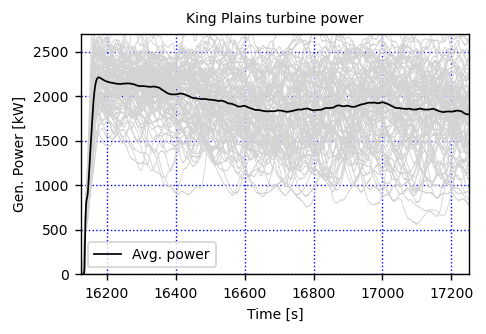

In [9]:
turblist = getturbnames(getTurbSubset(setupdir+'/'+summitcsv, '-KP'))
avgpower = None
toffset  = 16125
fig, ax = plt.subplots(1,1,figsize=(4,2.5), dpi=125)
for turb in turblist:
    turbdir = setupdir+'/'+OFoutdir+'/'+turb+OFdirsuffix
    searchpattern = turbdir+'/'+OFturbpattern
    outfilelist=glob.glob(searchpattern)
    #print(searchpattern, outfilelist)
    #print(outfilelist[0])
    OFout = readoutfile(outfilelist[0])
    time = OFout['Time']
    if avgpower is None:
        avgpower = OFout['GenPwr'][:]
    else:
        avgpower += OFout['GenPwr'][:]
    ax.plot(time+toffset, OFout['GenPwr'], color='lightgray', lw=0.5, label='')
    del OFout
    
avgpower /= len(turblist)
ax.plot(time+toffset, avgpower, color='k', lw=1, label='Avg. power')

ax.set_title('King Plains turbine power')
ax.set_ylim([0, 2700])
ax.set_xlim([16125, 17250])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Gen. Power [kW]')
ax.legend(prop={'size':fontsize})
ax.grid(ls=':', color='b')
setfigtextsize(ax,fontsize)